# First models

In [8]:
import numpy as np
import optuna
import pandas as pd
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier, plot_importance

from nlp_adversarial_attacks.reactdetect.utils.magic_vars import PRIMARY_KEY_FIELDS

In [2]:
path_to_pickle = "../data_tcab/whole_feature_dataset_with_canine.pickle"
objective = "binary"
model_type = "xgboost"
feature_set = "tl"
scaler = "StandardScaler"
pca = False
n_trials = 10
n_jobs = -1

In [3]:
# Load the data
df = pd.read_pickle(path_to_pickle)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Separate the different features
tp_features = df.columns[df.columns.str.startswith("tp_")].tolist()
tp_bert_features = df.columns[df.columns.str.startswith("tp_bert_")].tolist()
lm_features = df.columns[df.columns.str.startswith("lm_")].tolist()
tm_features = df.columns[df.columns.str.startswith("tm_")].tolist()
canine_features = df.columns[df.columns.str.startswith("canine_tp_bert_")].tolist()
feature_sets = {
    "bert": tp_bert_features,
    "t": tp_features,
    "tl": tp_features + lm_features,
    "tlc": tp_features + lm_features + tm_features,
    "canine": canine_features,
    "tlc_canine": tp_features + lm_features + tm_features + canine_features,
}
features = feature_sets[feature_set]

# Split the data into X and y
var_df = df.loc[:, features]
id_vars = ["unique_id"] + PRIMARY_KEY_FIELDS
index_df = df.loc[:, id_vars]
index_df["label"] = np.where(index_df["attack_name"] == "clean", "clean", "attack")
del df

# Split train and test sets
label_var = "label" if objective == "binary" else "attack_name"
train_idx, test_idx = train_test_split(
    var_df.index,
    test_size=0.2,
    random_state=42,
)
X_train, X_test = var_df.loc[train_idx], var_df.loc[test_idx]
y_train, y_test = index_df.loc[train_idx, label_var], index_df.loc[test_idx, label_var]
del var_df

# Encode the labels
le = LabelEncoder().fit(y_train)
y_train_enc, y_test_enc = le.transform(y_train), le.transform(y_test)
int_to_label = {i: label for i, label in enumerate(le.classes_)}

In [55]:
steps = [
    ("scaler", StandardScaler()),
    ("classifier", XGBClassifier()),
]
model = Pipeline(steps=steps)

In [56]:
scores = cross_validate(
    model,
    X_train,
    y_train_enc,
    cv=5,
    scoring=["accuracy", "f1", "precision", "recall"],
    return_estimator=True,
    n_jobs=-1,
)

In [57]:
scores["test_accuracy"].mean()

0.9146096166205115

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

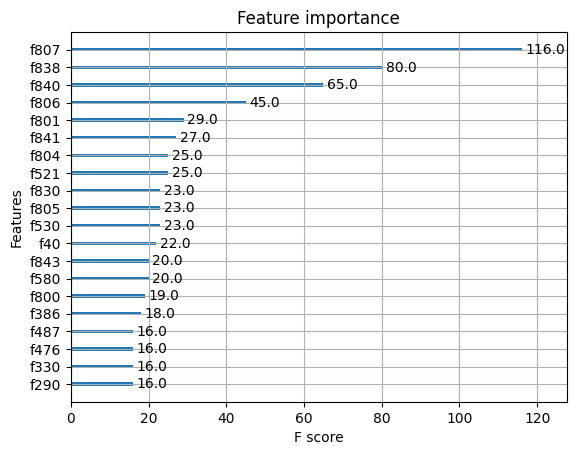

In [67]:
plot_importance(scores["estimator"][0][1], max_num_features=20)

In [65]:
scores["estimator"][0][1]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [76]:
importance_dict = {
    f: scores["estimator"][0][1].feature_importances_[i]
    for i, f in enumerate(X_train.columns)
}

In [78]:
sorted_features = sorted(
    importance_dict.items(), key=lambda x: np.abs(x[1]), reverse=True
)

In [79]:
sorted_features

[('tp_bert_130', 0.04443587),
 ('lm_perplexity_3', 0.027014993),
 ('tp_num_words_0', 0.017790321),
 ('tp_bert_415', 0.013273068),
 ('tp_bert_515', 0.01141183),
 ('tp_num_chars_0', 0.010480453),
 ('tp_bert_447', 0.008535264),
 ('tp_bert_87', 0.007628453),
 ('tp_bert_93', 0.007364925),
 ('tp_bert_141', 0.007026377),
 ('tp_bert_361', 0.006119042),
 ('tp_bert_257', 0.0059587345),
 ('lm_proba_and_rank_5', 0.0057193353),
 ('tp_bert_113', 0.005674213),
 ('tp_num_cased_letters_1', 0.004957556),
 ('tp_bert_175', 0.004673059),
 ('tp_num_mixed_case_words_0', 0.0045592906),
 ('lm_proba_and_rank_32', 0.0044420846),
 ('tp_bert_434', 0.0042918716),
 ('tp_num_single_lowercase_letters_0', 0.00415818),
 ('tp_bert_623', 0.0040500676),
 ('tp_bert_119', 0.003990644),
 ('tp_bert_54', 0.003876002),
 ('lm_proba_and_rank_30', 0.003873788),
 ('tp_bert_376', 0.0038400171),
 ('tp_bert_310', 0.0038306038),
 ('lm_proba_and_rank_35', 0.003795091),
 ('tp_num_punctuation_0', 0.0036779),
 ('tp_bert_307', 0.003637895),


In [5]:
# Define the objective function
def objective_function(trial):
    if model_type == "lr":
        lr_c = trial.suggest_float("lr_c", 1e-5, 1e5, log=True)
        classifier_obj = sklearn.linear_model.LogisticRegression(C=lr_c, max_iter=100)
    elif model_type == "xgboost":
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 16, log=True)
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 10, 100, log=True)
        classifier_obj = XGBClassifier(
            max_depth=xgb_max_depth, n_estimators=xgb_n_estimators
        )

    # Preprocessing steps (scaler and PCA)
    print("-- Building pipeline")
    steps = []
    if scaler == "None":
        steps.append(("scaler", "passthrough"))
    elif scaler == "StandardScaler":
        steps.append(("scaler", StandardScaler()))
    elif scaler == "MinMaxScaler":
        steps.append(("scaler", MinMaxScaler()))

    if pca:
        pca_n_components = trial.suggest_int("pca_n_components", 25, 250, log=True)
        steps.append(("pca", PCA(n_components=pca_n_components)))

    steps.append(("classifier", classifier_obj))
    pipe = Pipeline(steps)
    print(pipe)

    print("-- Training")
    pipe.fit(X_train, y_train_enc)

    print("-- Evaluating")
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test_enc, y_pred)

    return accuracy

In [6]:
study_name = f"{objective}_{model_type}_{feature_set}_{scaler.lower()}_{'pca' if pca else 'nopca'}"
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction="maximize",
)
# study = optuna.create_study(study_name=study_name, direction="maximize")
study.optimize(
    objective_function, n_trials=n_trials, show_progress_bar=True, n_jobs=n_jobs
)

[I 2023-03-15 20:09:55,359] A new study created in RDB with name: binary_xgboost_tlc_standardscaler_nopca
/home/gwatk/.cache/pypoetry/virtualenvs/nlp-adversarial-attacks-kOPV8VHT-py3.10/lib/python3.10/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

-- Building pipeline
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None,

In [ ]:
df = pd.read_pickle("../data_tcab/whole_feature_dataset.pickle")

In [ ]:
tp_features = df.columns[df.columns.str.startswith("tp_")].tolist()
tp_bert_features = df.columns[df.columns.str.startswith("tp_bert_")].tolist()
lm_features = df.columns[df.columns.str.startswith("lm_")].tolist()
tm_features = df.columns[df.columns.str.startswith("tm_")].tolist()

In [ ]:
id_vars = [
    "unique_id",
    "attack_name",
    "attack_toolchain",
    "attack_id",
    "scenario",
    "target_model",
    "target_model_dataset",
    "attack_id_bis",
]
index_df = df.loc[:, id_vars]
index_df["label"] = np.where(index_df["attack_name"] == "clean", 0, 1)
var_df = df.drop(id_vars, axis=1)

In [ ]:
train_idx, test_idx, y_train, y_test = train_test_split(
    var_df.index,
    index_df["label"],
    test_size=0.2,
    random_state=42,
    stratify=index_df["label"],
)
X_train, X_test = var_df.loc[train_idx], var_df.loc[test_idx]

In [ ]:
pipe = make_pipeline(
    StandardScaler(), PCA(100), LogisticRegression(max_iter=1000, random_state=42)
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
# 1. Define an objective function to be maximized.
def objective(trial):
    feature_subset = trial.suggest_categorical(
        "feature_subset",
        ["tp_features", "tp_bert_features", "lm_features", "tm_features"],
    )
    feature_dict = {
        "tp_bert_features": tp_bert_features,
        "tp_features": tp_features,
        "lm_features": tp_features + lm_features,
        "tm_features": tp_features + lm_features + tm_features,
    }
    feature_selector = ColumnTransformer(
        transformers=[("selector", "passthrough", feature_dict[feature_subset])],
        remainder="drop",
    )

    classifier_name = trial.suggest_categorical(
        "classifier", ["LogisticRegression", "XGBoost"]
    )
    if classifier_name == "LogisticRegression":
        lr_c = trial.suggest_float("lr_c", 1e-10, 1e10, log=True)
        lr_penalty = trial.suggest_categorical("lr_penalty", [None, "l1", "l2"])
        classifier_obj = sklearn.linear_model.LogisticRegression(
            C=lr_c, penalty=lr_penalty, solver="saga", max_iter=1000
        )
    elif classifier_name == "XGBoost":
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 10, 500, log=True)
        classifier_obj = XGBClassifier(
            max_depth=xgb_max_depth, n_estimators=xgb_n_estimators
        )

    scaler_name = trial.suggest_categorical(
        "scaler", ["None", "StandardScaler", "StandardScaler+PCA"]
    )
    if scaler_name == "None":
        preprocessor = Pipeline([("preprocessor", "passthrough")])
    elif scaler_name == "StandardScaler":
        preprocessor = Pipeline([("scaler", StandardScaler())])
    elif scaler_name == "StandardScaler+PCA":
        pca_n_components = trial.suggest_int("pca_n_components", 25, 250, log=True)
        preprocessor = Pipeline(
            [("scaler", StandardScaler()), ("pca", PCA(n_components=pca_n_components))]
        )

    pipe = Pipeline(
        [
            ("selector", feature_selector),
            ("preprocessor", preprocessor),
            ("classifier", classifier_obj),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)